In [1]:
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import nltk
import re
from typing import Dict, List, Tuple, Any
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/glebpsenicnikov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/glebpsenicnikov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Создание словарей

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from tqdm import tqdm
import random
import json
from collections import Counter

def extract_ngrams(texts, n, k):
    ngram = Counter()
    for text in tqdm(texts, desc="Counting ngram", leave=False):
        temp_text = text.split()
        large = len(temp_text) - n + 1
        for i in range(large):
            x = tuple(temp_text[i:i+n])
            ngram[x] += 1
    return ngram.most_common(k)

def get_model_predictions(model, tokenizer, ngrams, k):
    predictions = {}
    progress_bar = tqdm(total=len(ngrams), desc="Getting model predictions", leave=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for ngram in ngrams:
        input_text = " ".join(ngram[0])
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
            top_probs, top_indices = torch.topk(probs, k)

            predictions[input_text] = {
                "probs": top_probs.cpu().tolist()[0],
                "indices": top_indices.cpu().tolist()[0]
            }

        progress_bar.update(1)

    progress_bar.close()
    return predictions

def generate_texts(model, tokenizer, prompts, max_new_tokens=100):
    all_texts = []
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        progress_bar = tqdm(total=len(prompts), desc="Generating texts", leave=False)
        for prompt in prompts:
            inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer.pad_token_id,
                do_sample=True,
                temperature=0.7
            )
            decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            all_texts.append(decoded_text)
            progress_bar.update(1)
        progress_bar.close()
    return all_texts

models = [
    "gpt2",
    "facebook/bart-base",
    "bigscience/bloom-560m",
    "facebook/opt-1.3b"
]


# n = 1 
# n = 2
n = 3
kol_of_ngram = 1000
kol_of_prob = 1000
kol_prom = 1000

dataset = load_dataset("Hello-SimpleAI/HC3", 'all')
prompts = dataset['train']['question']
random.shuffle(prompts)
prompts = prompts[:kol_prom]

predictions_by_model = {}

for model_name in models:
    print(f"Processing model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    generated_texts = generate_texts(model, tokenizer, prompts)
    ngrams = extract_ngrams(generated_texts, n, kol_of_ngram)
    model_predictions = get_model_predictions(model, tokenizer, ngrams, kol_of_prob)
    predictions_by_model = {**predictions_by_model, **model_predictions}

In [ ]:
# with open('stat_n_1.json', 'w', encoding='utf-8') as f:
#     json.dump(predictions_by_model, f, ensure_ascii=False, indent=2)

# with open('stat_n_2.json', 'w', encoding='utf-8') as f:
#     json.dump(predictions_by_model, f, ensure_ascii=False, indent=2)

with open('stat_n_3.json', 'w', encoding='utf-8') as f:
    json.dump(predictions_by_model, f, ensure_ascii=False, indent=2)

# Данные

In [146]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())
            data.append(json_obj)
    return pd.DataFrame(data)


train_d = load_jsonl('semeval/subtaskC_train.jsonl')
test_d = load_jsonl('semeval/subtaskC_dev.jsonl')

In [147]:
def process_data(df):
    def dots(text):
        return re.sub('\.+', '. ', text)
    
    def sentence_number(text, token_position):
        sentences = sent_tokenize(text)
        current_position = 0
        for i, sentence in enumerate(sentences):
            current_position += len(sentence.split())
            if token_position <= current_position:
                return i
        return len(sentences)
    
    processed_df = df.copy()
    for idx in processed_df.index:
        processed_df.at[idx, 'text'] = dots(processed_df.at[idx, 'text'])
        text = processed_df.at[idx, 'text']
        label_position = processed_df.at[idx, 'label']
        processed_df.at[idx, 'label'] = sentence_number(text, label_position)
    return processed_df

train_data = process_data(train_d)
test_data = process_data(test_d)

In [15]:
ans = test_data.copy()

In [ ]:
def count_tokens(text: str) -> int:
    return len(nltk.word_tokenize(text))

def combine_texts_random(input_file: str, output_file: str, num_combinations: int = None):
    
    df = load_jsonl(input_file)
    
    label_0_df = df[df['label'] == 0].reset_index(drop=True)
    label_1_df = df[df['label'] == 1].reset_index(drop=True)
    
    print(f"Найдено {len(label_0_df)} текстов с label=0")
    print(f"Найдено {len(label_1_df)} текстов с label=1")
    
    if len(label_0_df) == 0 or len(label_1_df) == 0:
        print("Ошибка: не найдены тексты с одной из меток!")
        return pd.DataFrame()
    
    max_combinations = min(len(label_0_df), len(label_1_df))
    if num_combinations is None:
        num_combinations = max_combinations
    else:
        num_combinations = min(num_combinations, max_combinations)
    
    print(f"Создаем {num_combinations} комбинаций...")
    
    label_0_df = label_0_df.sample(frac=1).reset_index(drop=True)
    label_1_df = label_1_df.sample(frac=1).reset_index(drop=True)
    
    combined_data = []
    
    for i in range(num_combinations):
        text_0 = label_0_df.iloc[i]['text']
        text_1 = label_1_df.iloc[i]['text']
        
        combined_text = text_0 + " " + text_1
        
        first_text_tokens = count_tokens(text_0)
        label_position = first_text_tokens
        
        combined_item = {
            'id': i,
            'text': combined_text,
            'label': label_position,
        }
        
        combined_data.append(combined_item)
    
    result_df = pd.DataFrame(combined_data)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for item in combined_data:
            clean_item = {
                'id': item['id'],
                'text': item['text'],
                'label': item['label']
            }
            f.write(json.dumps(clean_item) + '\n')
    
    print(f"Результат сохранен в {output_file}")
    return result_df

In [16]:
dop_train_data = combine_texts_random('pan25/train.jsonl', 'dop_train.jsonl', num_combinations=None)
dop_train_data_df = process_data(dop_train_data)

Найдено 75270 текстов с label=0
Найдено 95398 текстов с label=1
Создаем 75270 комбинаций...
Результат сохранен в dop_train.jsonl


In [17]:
def merge_df_simple(df1: pd.DataFrame, df2: pd.DataFrame, output_path: str):
    combined_df = pd.concat([df1, df2], ignore_index=True)
    
    combined_df['id'] = range(len(combined_df))
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for _, row in combined_df.iterrows():
            f.write(json.dumps(row.to_dict()) + '\n')
    
    print(f"Объединено {len(combined_df)} записей в {output_path}")
    return combined_df

train_data_extra = merge_df_simple(train_data, dop_train_data, "new_ids_merged.jsonl")

Объединено 78919 записей в new_ids_merged.jsonl


In [69]:
# len_of_sent = 0
# kol_of_sent = 0
# for i in range(505):
#     a = nltk.sent_tokenize(test_data['text'].loc[i])
#     len_of_sent += len(a)
#     kol_of_sent += 1

# print(len_of_sent / kol_of_sent)

# Классификация и определение границы

In [18]:
from sklearn.ensemble import RandomForestClassifier 

class TextBoundaryClassifier:
    def __init__(self):
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        self.scaler = StandardScaler()
        
    def calculate_perplexity_single_ngram(self, text: str, ngram_dict: Dict, n: int, vocab_size: int = 50000) -> float:
        """Вычисляет перплексию для одного конкретного типа n-грамм"""
        if not text or len(text.strip()) == 0:
            return float('inf')
            
        total_log_prob = 0
        total_tokens = 0
        tokens = text.split()
        
        for i in range(len(tokens) - n + 1):
            ngram = " ".join(tokens[i:i+n])
            if ngram in ngram_dict:
                next_token = tokens[i+n] if i+n < len(tokens) else ""
                probs = ngram_dict[ngram]["probs"]
                indices = ngram_dict[ngram]["indices"]
                
                if next_token:
                    if next_token in indices:
                        idx = indices.index(next_token)
                        prob = probs[idx]
                    else:
                        remaining_prob = 1.0 - sum(probs)
                        prob = remaining_prob / (vocab_size - len(indices))
                    
                    if prob > 0:  # Избегаем log(0)
                        total_log_prob += np.log(prob)
                        total_tokens += 1
        
        if total_tokens == 0:
            return float('inf')
            
        return np.exp(-total_log_prob / total_tokens)
    
    def calculate_all_perplexities(self, text: str, ngram_dicts: List[Dict], vocab_size: int = 50000) -> Tuple[float, float, float]:
        perplexities = []
        
        for n, ngram_dict in enumerate(ngram_dicts, start=1):
            perplexity = self.calculate_perplexity_single_ngram(text, ngram_dict, n, vocab_size)
            if np.isinf(perplexity):
                perplexity = 0.0
            perplexities.append(perplexity)
        
        while len(perplexities) < 3:
            perplexities.append(0.0)
            
        return tuple(perplexities[:3])
    
    def extract_features(self, text: str, ngram_dicts: List[Dict]) -> List[float]:
        sentences = nltk.sent_tokenize(text)
        features = []
                all_perplexities_1gram = []
        all_perplexities_2gram = []
        all_perplexities_3gram = []
        
        for sent in sentences:
            perp_1, perp_2, perp_3 = self.calculate_all_perplexities(sent, ngram_dicts)
            all_perplexities_1gram.append(perp_1)
            all_perplexities_2gram.append(perp_2)
            all_perplexities_3gram.append(perp_3)
        
        for i, sent in enumerate(sentences):
            perplexity_1gram = all_perplexities_1gram[i]
            perplexity_2gram = all_perplexities_2gram[i]
            perplexity_3gram = all_perplexities_3gram[i]
            
            word_count = len(sent.split())
            relative_position = i / len(sentences)
            
            perplexity_change_1gram = perplexity_1gram - all_perplexities_1gram[i-1] if i > 0 else 0
            perplexity_change_2gram = perplexity_2gram - all_perplexities_2gram[i-1] if i > 0 else 0
            perplexity_change_3gram = perplexity_3gram - all_perplexities_3gram[i-1] if i > 0 else 0
            
            window_start = max(0, i-1)
            window_end = min(len(sentences), i+2)
            local_avg_perplexity_1gram = np.mean(all_perplexities_1gram[window_start:window_end])
            local_avg_perplexity_2gram = np.mean(all_perplexities_2gram[window_start:window_end])
            local_avg_perplexity_3gram = np.mean(all_perplexities_3gram[window_start:window_end])
            
            perplexity_deviation_1gram = perplexity_1gram - local_avg_perplexity_1gram
            perplexity_deviation_2gram = perplexity_2gram - local_avg_perplexity_2gram
            perplexity_deviation_3gram = perplexity_3gram - local_avg_perplexity_3gram
            
            punct_count = len(re.findall(r'[.!?;:,]', sent))
            capital_count = sum(1 for c in sent if c.isupper())
            digit_count = sum(1 for c in sent if c.isdigit())
            
            starts_with_capital = 1 if sent and sent[0].isupper() else 0
            ends_with_period = 1 if sent.strip().endswith('.') else 0
            
            char_count = len(sent)
            avg_word_length = np.mean([len(word) for word in sent.split()]) if sent.split() else 0
            
            features.append([
                perplexity_1gram,                 # 1. Перплексия по униграммам
                perplexity_2gram,                 # 2. Перплексия по биграммам
                perplexity_3gram,                 # 3. Перплексия по триграммам
                word_count,                       # 4. Количество слов
                relative_position,                # 5. Относительная позиция
                perplexity_change_1gram,         # 6. Изменение перплексии (униграммы)
                perplexity_change_2gram,         # 7. Изменение перплексии (биграммы)
                perplexity_change_3gram,         # 8. Изменение перплексии (триграммы)
                local_avg_perplexity_1gram,      # 9. Локальная средняя (униграммы)
                local_avg_perplexity_2gram,      # 10. Локальная средняя (биграммы)
                local_avg_perplexity_3gram,      # 11. Локальная средняя (триграммы)
                perplexity_deviation_1gram,      # 12. Отклонение от локальной средней (униграммы)
                perplexity_deviation_2gram,      # 13. Отклонение от локальной средней (биграммы)
                perplexity_deviation_3gram,      # 14. Отклонение от локальной средней (триграммы)
                punct_count,                     # 15. Количество знаков препинания
                capital_count,                   # 16. Количество заглавных букв
                digit_count,                     # 17. Количество цифр
                starts_with_capital,             # 18. Начинается с заглавной
                ends_with_period,                # 19. Заканчивается точкой
                char_count,                      # 20. Количество символов
                avg_word_length                  # 21. Средняя длина слова
            ])
            
        return features

    def train(self, train_df: pd.DataFrame, ngram_dicts: List[Dict], 
              text_col: str = 'text', boundary_col: str = 'label'):
        X = []
        y = []
        
        for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
            text = str(row[text_col])
            boundary = int(row[boundary_col])
            
            features = self.extract_features(text, ngram_dicts)
            sentences = nltk.sent_tokenize(text)
            
            labels = [1 if i >= boundary else 0 for i in range(len(sentences))]
            
            X.extend(features)
            y.extend(labels)
        
        X = np.array(X)
        y = np.array(y)
        X_scaled = self.scaler.fit_transform(X)
        self.classifier.fit(X_scaled, y)
        
    def calculate_gini(self, labels: List[int]) -> float:
        if not labels:
            return 0.0
            
        total = len(labels)
        counts = Counter(labels)
        gini = 1.0
        
        for count in counts.values():
            p = count / total
            gini -= p * p
            
        return gini

    def find_optimal_split_with_min(self, labels: List[int], pred_probs: List[float], min_count: int) -> int:
        best_split = 0
        min_gini = float('inf')
        valid_split_found = False
        
        for i in range(len(labels) - min_count + 1):
            if all(prob >= 0.5 for prob in pred_probs[i:i+min_count]):
                left_labels = labels[:i]
                right_labels = labels[i:]
                
                left_weight = len(left_labels) / len(labels)
                right_weight = len(right_labels) / len(labels)
                
                left_gini = self.calculate_gini(left_labels)
                right_gini = self.calculate_gini(right_labels)
                
                weighted_gini = left_weight * left_gini + right_weight * right_gini
                
                if weighted_gini < min_gini:
                    min_gini = weighted_gini
                    best_split = i
                    valid_split_found = True
        
        if not valid_split_found:
            max_prob_sum = -1
            max_prob_start = 0
            
            for i in range(len(pred_probs) - min_count + 1):
                window_prob_sum = sum(pred_probs[i:i+min_count])
                if window_prob_sum > max_prob_sum:
                    max_prob_sum = window_prob_sum
                    max_prob_start = i
            
            best_split = max_prob_start
        
        return best_split

    def predict(self, text: str, ngram_dicts: List[Dict], min_generated_sentences: int = 3) -> Tuple[int, List[float], List[int], int]:
        sentences = nltk.sent_tokenize(text)
        
        if len(sentences) < min_generated_sentences:
            raise ValueError(f"Text contains fewer sentences ({len(sentences)}) than required minimum generated sentences ({min_generated_sentences})")
        
        features = self.extract_features(text, ngram_dicts)
        X = self.scaler.transform(features)
        
        pred_labels = self.classifier.predict(X)
        pred_probs = self.classifier.predict_proba(X)[:, 1]
        
        best_boundary = self.find_optimal_split_with_min(
            pred_labels.tolist(), 
            pred_probs.tolist(), 
            min_generated_sentences
        )
        
        token_position = sum(len(sent.split()) for sent in sentences[:best_boundary])
        
        final_labels = [0] * len(sentences)
        for i in range(best_boundary, len(sentences)):
            final_labels[i] = 1
        
        return best_boundary, pred_probs.tolist(), final_labels, token_position
    
    def evaluate(self, test_df: pd.DataFrame, ngram_dicts: List[Dict], 
                text_col: str = 'text', boundary_col: str = 'label',
                min_generated_sentences: int = 3) -> Dict:
        results = []
        all_true_labels = []
        all_pred_labels = []
        
        for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
            text = str(row[text_col])
            true_boundary = int(row[boundary_col])
            
            try:
                pred_boundary, probs, pred_labels, token_position = self.predict(
                    text, ngram_dicts, min_generated_sentences=min_generated_sentences
                )
                
                sentences = nltk.sent_tokenize(text)
                
                true_labels = [0] * len(sentences)
                for i in range(true_boundary, len(sentences)):
                    true_labels[i] = 1
                
                all_true_labels.extend(true_labels)
                all_pred_labels.extend(pred_labels)
                
                results.append({
                    'text_id': row.name,
                    'true_boundary': true_boundary,
                    'pred_boundary': pred_boundary,
                    'token_position': token_position,
                    'boundary_error': abs(pred_boundary - true_boundary),
                    'num_sentences': len(sentences),
                })
            except ValueError as e:
                continue
                
        if not results:
            return {
                'boundary_detection': {
                    'mean_error': 0,
                    'median_error': 0,
                    'max_error': 0,
                    'exact_matches': 0,
                    'within_one': 0,
                    'recall': 0
                },
                'detailed_results': pd.DataFrame()
            }
        
        results_df = pd.DataFrame(results)
        
        recall = recall_score(all_true_labels, all_pred_labels)
        acc = accuracy_score(all_true_labels, all_pred_labels)
        
        metrics = {
            'boundary_detection': {
                'mean_error': results_df['boundary_error'].mean(),
                'median_error': results_df['boundary_error'].median(),
                'max_error': results_df['boundary_error'].max(),
                'exact_matches': (results_df['boundary_error'] == 0).mean(),
                'within_one': (results_df['boundary_error'] <= 1).mean(),
                'recall': recall,
                'acc': acc,
            },
            'detailed_results': results_df
        }
        
        return metrics

    def save_predictions(self, test_df: pd.DataFrame, ngram_dicts: List[Dict], 
                        output_path: str, min_generated_sentences: int = 3) -> None:
        with open(output_path, 'w', encoding='utf-8') as f:
            for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating predictions"):
                text = str(row['text'])
                
                try:
                    pred_boundary, _, _, _ = self.predict(
                        text, ngram_dicts, min_generated_sentences=min_generated_sentences
                    )
                    
                    prediction = {
                        "id": row.name,
                        "label": pred_boundary
                    }
                except ValueError as e:
                    prediction = {
                        "id": row.name,
                        "label": 0
                    }
                
                f.write(json.dumps(prediction) + '\n')
    
    def calculate_token_perplexities_unigram(self, text: str, ngram_dicts: List[Dict], 
                                         vocab_size: int = 50000) -> List[float]:
        if not text or len(text.strip()) == 0:
            return []
            
        tokens = text.split()
        token_perplexities = []
        window_size = 10
        
        unigram_dict = ngram_dicts[0] if ngram_dicts else {}
        
        for i in range(len(tokens)):
            start = max(0, i - window_size)
            end = min(len(tokens), i + 1)
            window_text = " ".join(tokens[start:end])
            
            perplexity = self.calculate_perplexity_single_ngram(window_text, unigram_dict, 1, vocab_size)
            if np.isinf(perplexity):
                perplexity = 0.0
                
            token_perplexities.append(perplexity)
            
        return token_perplexities
    
    def plot_perplexity_continuous(self, text: str, ngram_dicts: List[Dict], 
                                true_boundary: int = None, pred_boundary: int = None,
                                window_size: int = 5, save_path: str = None) -> None:
        sentences = nltk.sent_tokenize(text)
        sentence_perplexities = []
        
        unigram_dict = ngram_dicts[0] if ngram_dicts else {}
        
        for sent in sentences:
            perplexity = self.calculate_perplexity_single_ngram(sent, unigram_dict, 1)
            if np.isinf(perplexity):
                perplexity = 0.0
            sentence_perplexities.append(perplexity)
        
        plt.figure(figsize=(12, 6))
        sns.set(style='whitegrid')
        
        plt.rcParams.update({
            'font.size': 16,
            'axes.labelsize': 18,
            'axes.titlesize': 20,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14,
            'legend.fontsize': 16
        })
        
        plt.plot(range(len(sentence_perplexities)), sentence_perplexities, 
             marker='o', markersize=8,
             markerfacecolor='blue',
             markeredgecolor='black',
             markeredgewidth=1.5,
             linestyle='--',
             linewidth=1,
             alpha=0.5)
        
        if pred_boundary is not None:
            plt.axvline(x=pred_boundary, color='r', linestyle='--', 
                       label='Предсказанная граница', linewidth=2)
        
        plt.xlabel('Номер предложения')
        plt.ylabel('Перплексия')
        # plt.title('Изменение перплексии по предложениям (униграммы)')
        plt.legend()
        
        if save_path:
            eps_path = save_path.replace('.png', '.eps')
            plt.savefig(eps_path, format='eps', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_token_perplexity_timeseries(self, text: str, ngram_dicts: List[Dict],
                                        true_boundary_token: int = None, 
                                        pred_boundary_token: int = None,
                                        save_path: str = None) -> None:
    
        tokens = text.split()
        token_perplexities = self.calculate_token_perplexities_unigram(text, ngram_dicts)
        
        plt.figure(figsize=(14, 7))
        sns.set(style='whitegrid')
        
        plt.rcParams.update({
            'font.size': 16,
            'axes.labelsize': 18,
            'axes.titlesize': 20,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14,
            'legend.fontsize': 16
        })
        
        plt.plot(range(len(token_perplexities)), token_perplexities, 
                 marker='.', markersize=3, linestyle='-', linewidth=1.5, alpha=0.7)
        
        window_size = min(30, len(token_perplexities) // 5)
        if window_size > 2:
            smoothed = pd.Series(token_perplexities).rolling(window=window_size, center=True).mean()
            plt.plot(range(len(smoothed)), smoothed, color='red', linewidth=2, 
                    label=f'Скользящее среднее (окно={window_size})')
        
        if pred_boundary_token is not None:
            plt.axvline(x=pred_boundary_token, color='r', linestyle='--', 
                       label='Предсказанная граница', linewidth=2)
        
        plt.xlabel('Позиция токена')
        plt.ylabel('Перплексия (униграммы)')
        # plt.title('Изменение перплексии по токенам (униграммы)')
        plt.legend()
        
        if save_path:
            eps_path = save_path.replace('.png', '.eps')
            plt.savefig(eps_path, format='eps', dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_sample(self, text: str, ngram_dicts: List[Dict], 
                      true_boundary: int = None, 
                      min_generated_sentences: int = 3) -> Dict[str, Any]:
        sentences = nltk.sent_tokenize(text)
        
        pred_boundary, pred_probs, pred_labels, token_position = self.predict(
            text, ngram_dicts, min_generated_sentences=min_generated_sentences
        )
        
        true_token_position = None
        if true_boundary is not None:
            true_token_position = sum(len(sent.split()) for sent in sentences[:true_boundary])
        
        print(f"Текст содержит {len(sentences)} предложений")
        print(f"Предсказанная граница: {pred_boundary} предложение ({token_position} токен)")
        if true_boundary is not None:
            print(f"Истинная граница: {true_boundary} предложение ({true_token_position} токен)")
            print(f"Ошибка (по предложениям): {abs(pred_boundary - true_boundary)}")
            print(f"Ошибка (по токенам): {abs(token_position - true_token_position)}")
        
        self.plot_perplexity_continuous(
            text, ngram_dicts, true_boundary, pred_boundary, 
            save_path='perplexity_continuous.png'
        )
        
        self.plot_token_perplexity_timeseries(
            text, ngram_dicts, true_token_position, token_position, 
            save_path='token_perplexity_timeseries.png'
        )
        
        results = {
            'num_sentences': len(sentences),
            'pred_boundary': pred_boundary,
            'pred_token_position': token_position,
            'true_boundary': true_boundary,
            'true_token_position': true_token_position,
            'sentence_error': abs(pred_boundary - true_boundary) if true_boundary is not None else None,
            'token_error': abs(token_position - true_token_position) if true_token_position is not None else None,
        }
        
        return results


# SemEval

In [148]:
ngram_paths = ["stat_n_1.json", "stat_n_2.json", "stat_n_3.json"]
ngram_dicts = []
for path in ngram_paths:
    with open(path, 'r', encoding='utf-8') as f:
        ngram_dicts.append(json.load(f))

detector = TextBoundaryClassifier()
detector.train(train_data, ngram_dicts)

100%|██████████████████████████████████████| 3649/3649 [00:08<00:00, 441.30it/s]


In [162]:
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [163]:
%%time
metrics = detector.evaluate(test_data, ngram_dicts, min_generated_sentences=2)

if metrics:
    boundary_metrics = metrics['boundary_detection']
    print(f"Средняя ошибка: {boundary_metrics['mean_error']:.2f} предложение")
    print(f"Медианная: {boundary_metrics['median_error']:.2f} предложение")
    print(f"Точное попадание: {boundary_metrics['exact_matches']*100:.1f}%")
    print(f"±1 предложение: {boundary_metrics['within_one']*100:.1f}%")
    print(f"Recall: {boundary_metrics['recall']*100:.1f}%")
    print(f"Accuracy: {boundary_metrics['acc']*100:.1f}%")

# detector.save_predictions(test_data, ngram_dicts, "semeval/predictions.jsonl", min_generated_sentences=2)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 30.02it/s]

Средняя ошибка: 1.00 предложение
Медианная: 0.00 предложение
Точное попадание: 60.0%
±1 предложение: 60.0%
Recall: 100.0%
Accuracy: 92.4%
CPU times: user 181 ms, sys: 49.8 ms, total: 231 ms
Wall time: 338 ms


In [7]:
import json
from typing import List, Dict
from tqdm import tqdm

def create_data_gold(test_data, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for idx, row in test_data.iterrows():
            data = {
                'id': row['id'],
                'label': int(row['label'])
            }
            f.write(json.dumps(data) + '\n')

def create_data_pred(input_file: str, output_file: str, ids):
    with open(input_file, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for item, idd in zip(data, ids):
            label = {
                "id": idd,
                "label": int(item['label'])
            }
            f.write(json.dumps(label) + '\n')

In [8]:
with open('semeval/subtaskC_dev.jsonl', 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]
    ids = [item['id'] for item in data]

create_data_gold(test_data, 'semeval/gold_labels_class.jsonl')
create_data_pred('semeval/predictions.jsonl', 'semeval/predictions_class.jsonl', ids)

In [9]:
!python3.11 scorer.py --gold_file_path=semeval/gold_labels_class.jsonl --pred_file_path=semeval/predictions_class.jsonl

INFO : Prediction file format is correct
INFO : Number of samples: 505
INFO : Mean Absolute Error=1.02574


In [172]:
len_of_sent = 0
kol_of_sent = 0
for i in range(10):
    a = nltk.sent_tokenize(test_data['text'].loc[i])
    len_of_sent += len(a)
    kol_of_sent += 1

print(len_of_sent / kol_of_sent)

13.1


#  Графики

In [26]:
%config InlineBackend.figure_format = 'svg'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Текст содержит 13 предложений
Предсказанная граница: 3 предложение (80 токен)
Истинная граница: 3 предложение (80 токен)
Ошибка (по предложениям): 0
Ошибка (по токенам): 0


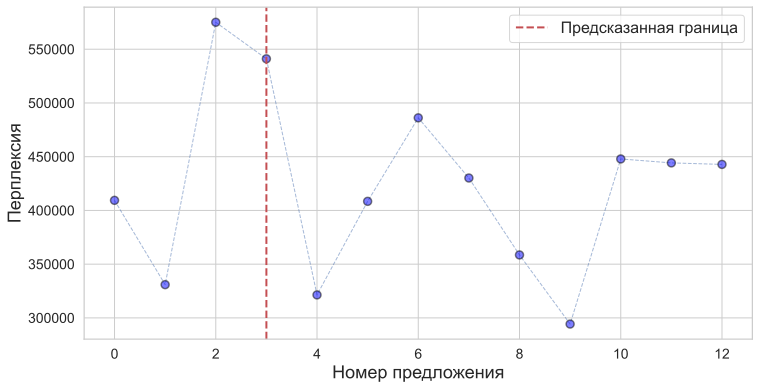

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


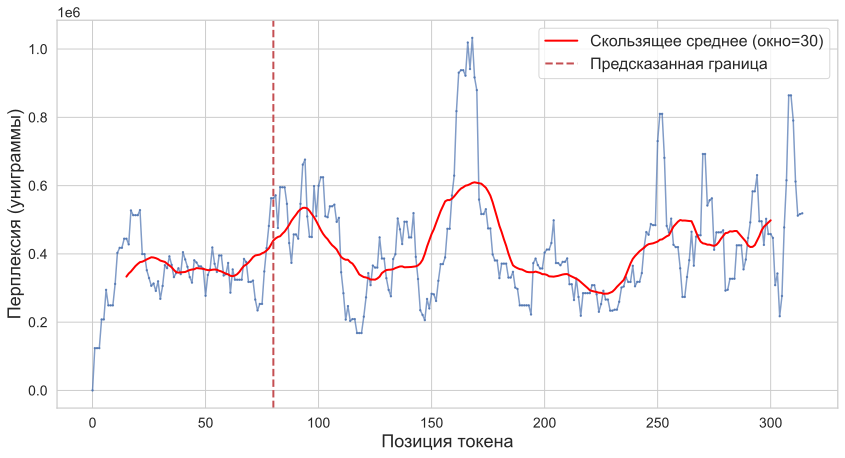

{'num_sentences': 13,
 'pred_boundary': 3,
 'pred_token_position': 80,
 'true_boundary': 3,
 'true_token_position': 80,
 'sentence_error': 0,
 'token_error': 0}

In [33]:
idx = 0
sample_text = test_data.iloc[idx]['text']
sample_true_boundary = test_data.iloc[idx]['label']
detector.analyze_sample(sample_text, ngram_dicts, sample_true_boundary, min_generated_sentences=2)

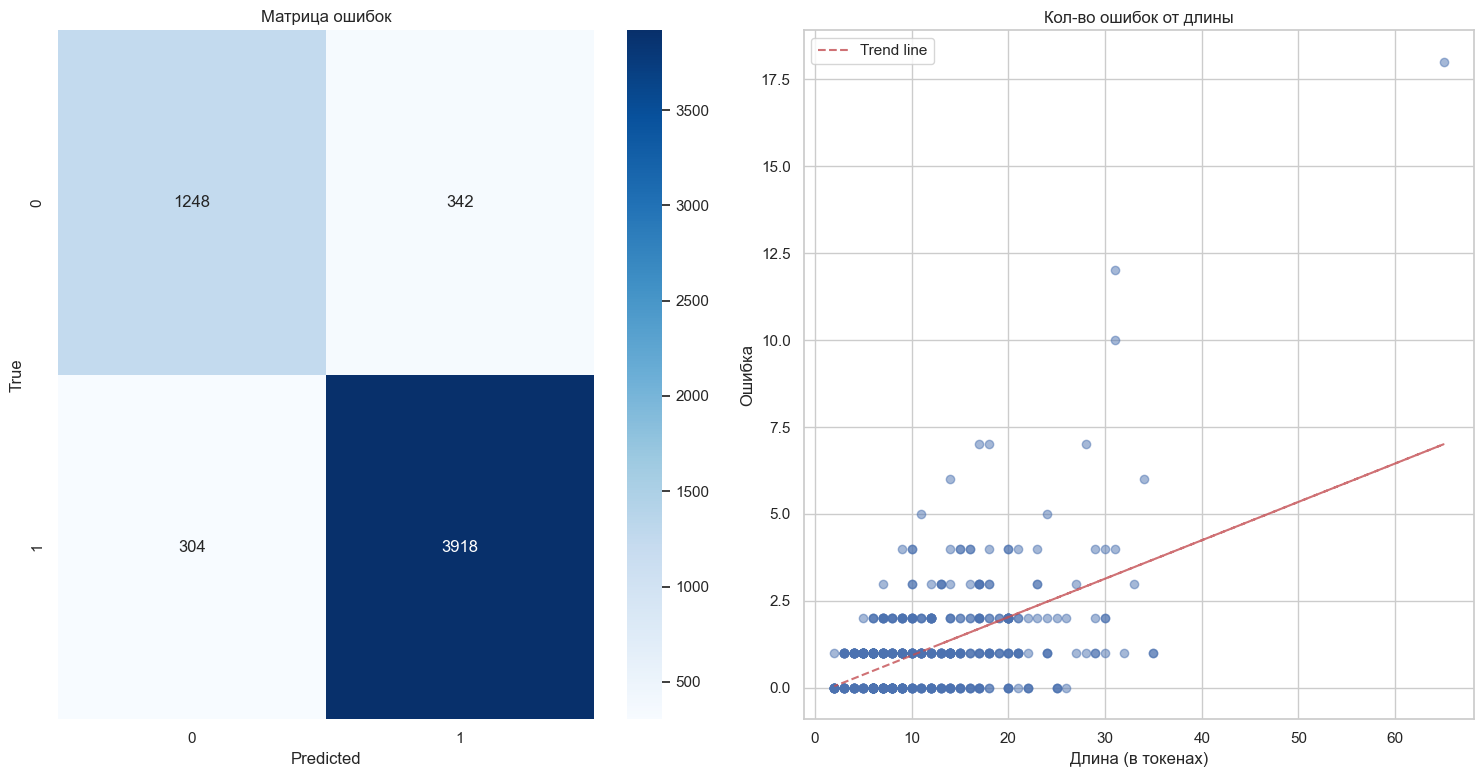

In [34]:
all_probs = []
all_true_labels = []
text_lengths = []
boundary_errors = []

for _, row in test_data.iterrows():
    text = str(row['text'])
    true_boundary = int(row['label'])
    try:
        pred_boundary, probs, pred_labels, _ = detector.predict(
            text, ngram_dicts, min_generated_sentences=2
        )
        text_length = len(nltk.sent_tokenize(text))
        
        sentences = nltk.sent_tokenize(text)
        true_labels = [1 if i >= true_boundary else 0 for i in range(len(sentences))]
        
        all_probs.extend(probs)
        all_true_labels.extend(true_labels)
        text_lengths.append(text_length)
        boundary_errors.append(abs(pred_boundary - true_boundary))
            
    except ValueError:
        continue

pred_labels_all = [1 if prob >= 0.5 else 0 for prob in all_probs]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

cm = confusion_matrix(all_true_labels, pred_labels_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Матрица ошибок')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')


axes[0, 1].scatter(text_lengths, boundary_errors, alpha=0.5)
axes[0, 1].set_title('Кол-во ошибок от длины')
axes[0, 1].set_xlabel('Длина (в токенах)')
axes[0, 1].set_ylabel('Ошибка')
z = np.polyfit(text_lengths, boundary_errors, 1)
p = np.poly1d(z)
axes[0, 1].plot(text_lengths, p(text_lengths), "r--", alpha=0.8, label=f'Trend line')
axes[0, 1].legend()

axes[1, 0].remove()
axes[1, 1].remove()

plt.tight_layout()
plt.savefig('analyze_png', dpi=300, bbox_inches='tight')
plt.show()

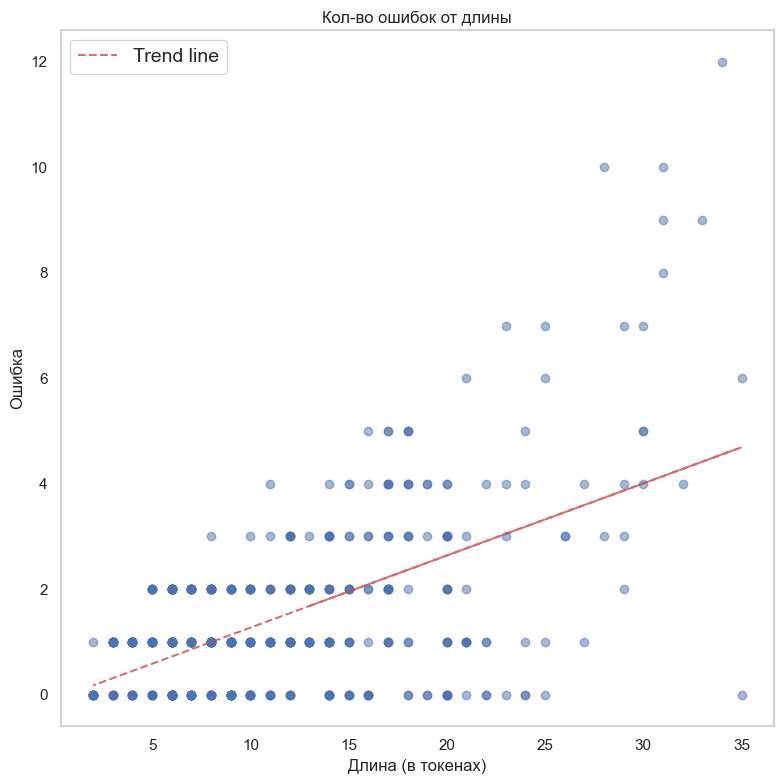

In [85]:
all_probs = []
all_true_labels = []
text_lengths = []
boundary_errors = []

for _, row in test_data.iterrows():
    text = str(row['text'])
    true_boundary = int(row['label'])
    try:
        pred_boundary, probs, pred_labels, _ = detector.predict(
            text, ngram_dicts, min_generated_sentences=2
        )
        text_length = len(nltk.sent_tokenize(text))
        
        sentences = nltk.sent_tokenize(text)
        true_labels = [1 if i >= true_boundary else 0 for i in range(len(sentences))]
        
        all_probs.extend(probs)
        all_true_labels.extend(true_labels)

        if text_length > 50:
            continue
        text_lengths.append(text_length)
        boundary_errors.append(abs(pred_boundary - true_boundary))
            
    except ValueError:
        continue


fig, axes = plt.subplots(figsize=(8, 8))

axes.scatter(text_lengths, boundary_errors, alpha=0.5)
axes.set_title('Кол-во ошибок от длины')
axes.set_xlabel('Длина (в токенах)')
axes.set_ylabel('Ошибка')
z = np.polyfit(text_lengths, boundary_errors, 1)
p = np.poly1d(z)
axes.plot(text_lengths, p(text_lengths), "r--", alpha=0.8, label=f'Trend line')
axes.legend(fontsize=14)

plt.grid()
plt.tight_layout()
plt.savefig('analyze_err.png', dpi=300, bbox_inches='tight')
plt.show()

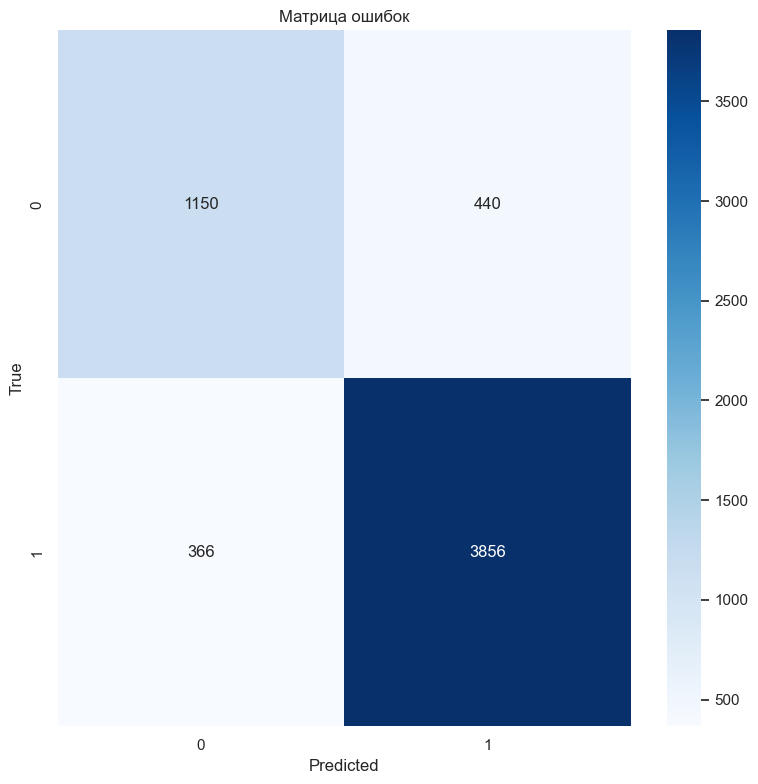

In [86]:
all_probs = []
all_true_labels = []
text_lengths = []
boundary_errors = []

for _, row in test_data.iterrows():
    text = str(row['text'])
    true_boundary = int(row['label'])
    try:
        pred_boundary, probs, pred_labels, _ = detector.predict(
            text, ngram_dicts, min_generated_sentences=2
        )
        text_length = len(nltk.sent_tokenize(text))
        
        sentences = nltk.sent_tokenize(text)
        true_labels = [1 if i >= true_boundary else 0 for i in range(len(sentences))]
        
        all_probs.extend(probs)
        all_true_labels.extend(true_labels)
        text_lengths.append(text_length)
        boundary_errors.append(abs(pred_boundary - true_boundary))
            
    except ValueError:
        continue

pred_labels_all = [1 if prob >= 0.5 else 0 for prob in all_probs]

fig, axes = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(all_true_labels, pred_labels_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
axes.set_title('Матрица ошибок')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

plt.tight_layout()
plt.savefig('mat_png', dpi=300, bbox_inches='tight')
plt.show()

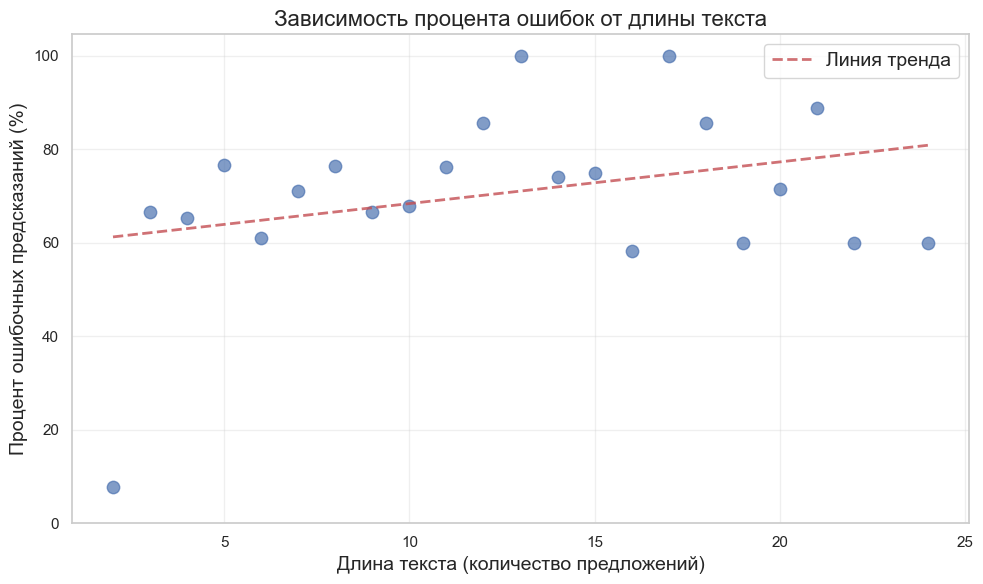

In [87]:
from collections import defaultdict

length_stats = defaultdict(lambda: {'total': 0, 'errors': 0})

for _, row in test_data.iterrows():
    text = str(row['text'])
    true_boundary = int(row['label'])
    try:
        pred_boundary, probs, pred_labels, _ = detector.predict(
            text, ngram_dicts, min_generated_sentences=2
        )
        
        sentences = nltk.sent_tokenize(text)
        text_length = len(sentences)
        
        is_error = pred_boundary != true_boundary
        
        length_stats[text_length]['total'] += 1
        if is_error:
            length_stats[text_length]['errors'] += 1
            
    except ValueError:
        continue

lengths = []
error_rates = []

for length, stats in sorted(length_stats.items()):
    if stats['total'] >= 5:
        lengths.append(length)
        error_rate = stats['errors'] / stats['total']
        error_rates.append(error_rate * 100)

fig, axes = plt.subplots(figsize=(10, 6))
axes.scatter(lengths, error_rates, alpha=0.7, s=80)
axes.set_title('Зависимость процента ошибок от длины текста', fontsize=16)
axes.set_xlabel('Длина текста (количество предложений)', fontsize=14)
axes.set_ylabel('Процент ошибочных предсказаний (%)', fontsize=14)

z = np.polyfit(lengths, error_rates, 1)
p = np.poly1d(z)
axes.plot(lengths, p(lengths), "r--", alpha=0.8, linewidth=2, label='Линия тренда')

# Настройка графика
axes.legend(fontsize=14)
axes.grid(True, alpha=0.3)
axes.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('error_rate_by_length.png', dpi=300, bbox_inches='tight')
plt.show()

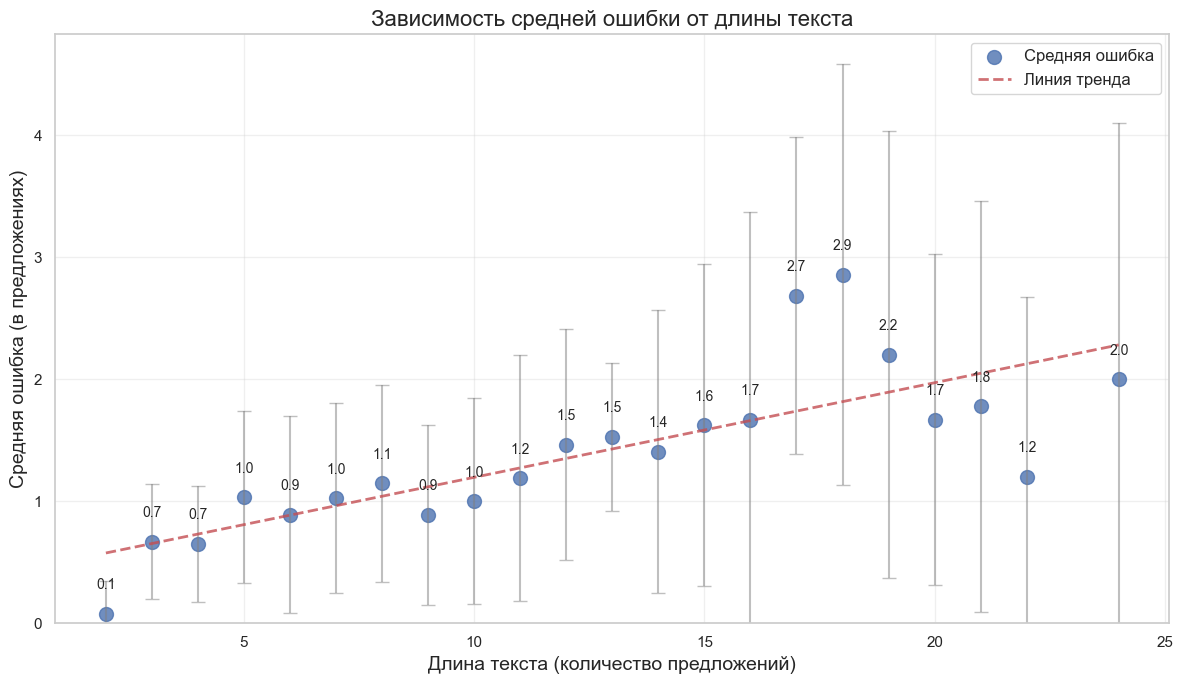

In [88]:
average_errors = defaultdict(list)

for _, row in test_data.iterrows():
    text = str(row['text'])
    true_boundary = int(row['label'])
    try:
        pred_boundary, probs, pred_labels, _ = detector.predict(
            text, ngram_dicts, min_generated_sentences=2
        )
        
        sentences = nltk.sent_tokenize(text)
        text_length = len(sentences)
        
        error_size = abs(pred_boundary - true_boundary)
        
        average_errors[text_length].append(error_size)
            
    except ValueError:
        continue

lengths = []
mean_errors = []
std_errors = []

for length, errors in sorted(average_errors.items()):
    if len(errors) >= 5:
        lengths.append(length)
        mean_errors.append(np.mean(errors))
        std_errors.append(np.std(errors))

fig, axes = plt.subplots(figsize=(12, 7))

axes.scatter(lengths, mean_errors, alpha=0.8, s=100, label='Средняя ошибка')

axes.errorbar(lengths, mean_errors, yerr=std_errors, fmt='none', alpha=0.5, 
              ecolor='gray', capsize=5)

for x, y in zip(lengths, mean_errors):
    axes.annotate(f"{y:.1f}", (x, y + 0.2), ha='center', fontsize=10)

z = np.polyfit(lengths, mean_errors, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(lengths), max(lengths), 100)
axes.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Линия тренда')

# Настройка графика
axes.set_title('Зависимость средней ошибки от длины текста', fontsize=16)
axes.set_xlabel('Длина текста (количество предложений)', fontsize=14)
axes.set_ylabel('Средняя ошибка (в предложениях)', fontsize=14)
axes.legend(fontsize=12)
axes.grid(True, alpha=0.3)
axes.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('error_size_by_length.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
len_of_sent = 0
kol_of_sent = 0
for i in range(505):
    a = nltk.sent_tokenize(test_data['text'].loc[i])
    for elem in a:
        len_of_sent += len(nltk.word_tokenize(elem))
        kol_of_sent += 1

print(len_of_sent / kol_of_sent)

22.50507483227249


In [112]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

length_stats = defaultdict(lambda: {'total': 0, 'errors': 0})
average_errors = defaultdict(list)

for _, row in tqdm(ans.iterrows(), total=len(ans), desc="Processing texts"):
    text = str(row['text'])
    true_boundary = int(row['label'])
    try:
        pred_boundary, probs, pred_labels, _ = detector.predict(
            text, ngram_dicts, min_generated_sentences=2
        )
        
        sentences = nltk.sent_tokenize(text)
        text_length = len(sentences)
        
        is_error = pred_boundary != true_boundary
        length_stats[text_length]['total'] += 1
        if is_error:
            length_stats[text_length]['errors'] += 1
        
        error_size = abs(pred_boundary - true_boundary)
        average_errors[text_length].append(error_size)
            
    except ValueError:
        continue

Processing texts: 100%|███████████████████| 63121/63121 [40:06<00:00, 26.23it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Создание первого графика...


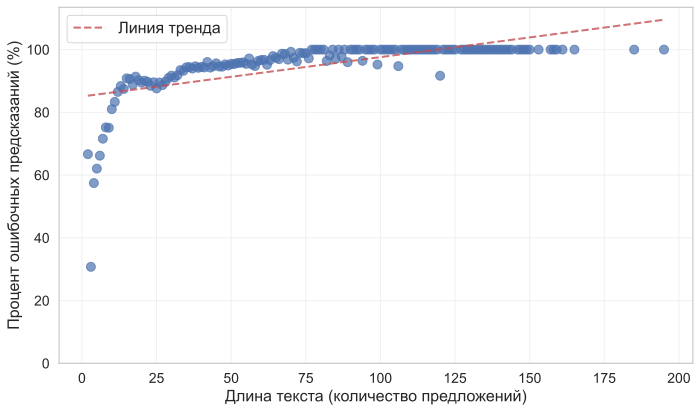

In [126]:
print("Создание первого графика...")
lengths_1 = []
error_rates = []
for length, stats in sorted(length_stats.items()):
    if stats['total'] >= 5:
        lengths_1.append(length)
        error_rate = stats['errors'] / stats['total']
        error_rates.append(error_rate * 100)

fig, axes = plt.subplots(figsize=(10, 6))
axes.scatter(lengths_1, error_rates, alpha=0.7, s=80)
# axes.set_title('Зависимость процента ошибок от длины текста', fontsize=16)
axes.set_xlabel('Длина текста (количество предложений)', fontsize=16)
axes.set_ylabel('Процент ошибочных предсказаний (%)', fontsize=16)

z = np.polyfit(lengths_1, error_rates, 1)
p = np.poly1d(z)
axes.plot(lengths_1, p(lengths_1), "r--", alpha=0.8, linewidth=2, label='Линия тренда')


axes.legend(fontsize=16)
axes.grid(True, alpha=0.3)
axes.set_ylim(bottom=0)
plt.tight_layout()
plt.savefig('error_rate_by_length.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Создание второго графика...


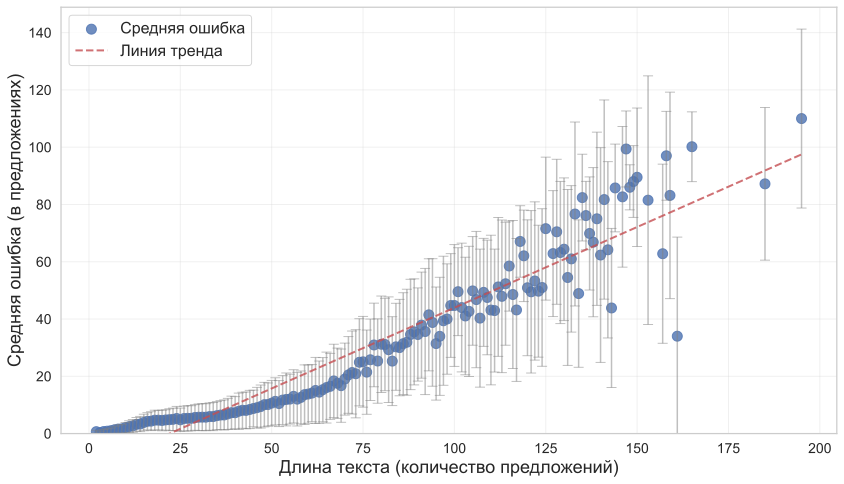

Анализ завершен!


In [125]:
print("Создание второго графика...")
lengths_2 = []
mean_errors = []
std_errors = []
for length, errors in sorted(average_errors.items()):
    if len(errors) >= 5:
        lengths_2.append(length)
        mean_errors.append(np.mean(errors))
        std_errors.append(np.std(errors))

fig, axes = plt.subplots(figsize=(12, 7))
axes.scatter(lengths_2, mean_errors, alpha=0.8, s=100, label='Средняя ошибка')
axes.errorbar(lengths_2, mean_errors, yerr=std_errors, fmt='none', alpha=0.5, 
              ecolor='gray', capsize=5)

# for x, y in zip(lengths_2, mean_errors):
#     axes.annotate(f"{y:.1f}", (x, y + 0.2), ha='center', fontsize=10)

z = np.polyfit(lengths_2, mean_errors, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(lengths_2), max(lengths_2), 100)
axes.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Линия тренда')

# axes.set_title('Зависимость средней ошибки от длины текста', fontsize=16)
axes.set_xlabel('Длина текста (количество предложений)', fontsize=18)
axes.set_ylabel('Средняя ошибка (в предложениях)', fontsize=18)
axes.legend(fontsize=16)
axes.grid(True, alpha=0.3)
axes.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('error_size_by_length.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

print("Анализ завершен!")

# DagPap 2024

In [84]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm

def deserialize_bytes(byte_data):
    if isinstance(byte_data, bytes):
        try:
            return json.loads(byte_data.decode('utf-8'))
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            return []
        except UnicodeDecodeError as e:
            print(f"Unicode decode error: {e}")
            return []
    return byte_data

In [85]:
def find_zero_to_two_transitions(labels, min_consecutive=5, balance_ratio=0.3):
    labels = np.array(labels)
    transitions = []
    i = 0
    
    while i < len(labels) - min_consecutive:
        if labels[i] == 0:
            zero_start = i
            zero_count = 0
            
            # Считаем количество подряд идущих нулей
            while i < len(labels) and labels[i] == 0:
                zero_count += 1
                i += 1
            
            # Проверяем минимальное количество нулей и что следом идут двойки
            if zero_count >= min_consecutive and i < len(labels) and labels[i] == 2:
                two_start = i
                two_count = 0
                
                # Считаем количество подряд идущих двоек
                while i < len(labels) and labels[i] == 2:
                    two_count += 1
                    i += 1
                
                # Проверяем минимальное количество двоек
                if two_count >= min_consecutive:
                    # Проверяем сбалансированность
                    min_count = min(zero_count, two_count)
                    max_count = max(zero_count, two_count)
                    difference = max_count - min_count
                    
                    if difference <= min_count * balance_ratio:
                        transitions.append((zero_start, two_start, i))
            else:
                continue
        else:
            i += 1
    
    return transitions

In [93]:
def extract_text_fragments(tokens_df, labels_df, output_file, min_consecutive=5):
    merged_df = tokens_df.merge(labels_df, left_on='index', right_index=True, how='inner')
    
    fragments = []
    fragment_id = 0
    
    for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        tokens = deserialize_bytes(row['tokens'])
        labels = deserialize_bytes(row['token_label_ids'])
        
        if len(tokens) != len(labels):
            print(f"Предупреждение: длины не совпадают для индекса {row['index']}")
            continue
        
        transitions = find_zero_to_two_transitions(labels, min_consecutive)
        
        for zero_start, two_start, two_end in transitions:
            fragment_tokens = tokens[zero_start:two_end]
            fragment_text = ' '.join(fragment_tokens)
            
            transition_position = two_start - zero_start
            
            fragments.append({
                'id': fragment_id,
                'text': fragment_text,
                'label': transition_position
            })
            
            fragment_id += 1
    
    result_df = pd.DataFrame(fragments)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in result_df.iterrows():
            data = {
                'id': row['id'],
                'text': row['text'],
                'label': int(row['label'])
            }
            f.write(json.dumps(data) + '\n')
    
    print(f"Найдено {len(fragments)} фрагментов с переходами 0->2")
        
    return result_df

In [94]:
tokens_df = pd.read_parquet('dagpap/test_data.parquet')
labels_df = pd.read_parquet('dagpap/test_data_labels.parquet') 

In [95]:
result_df = extract_text_fragments(
        tokens_df, 
        labels_df, 
        'dagpap/transition_fragments.jsonl',
        min_consecutive=5
)
test_data = process_data(result_df)

100%|████████████████████████████████████| 20000/20000 [00:20<00:00, 955.89it/s]


Найдено 1521 фрагментов с переходами 0->2


In [96]:
ans = pd.concat([ans, test_data], ignore_index=True)
ans

,id,text,label
0,085e6abb-48c7-4388-9d70-901c4b173369,The paper describes an extension of word embed...,3
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,Summary: This paper presents a model for embed...,4
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,The authors presents a method to jointly embed...,16
3,4de9ac55-2090-4da6-9431-40137992d68b,Dear Authors\r\n\r\nthanks for replying to our...,0
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,- Strengths:\r\n\r\n1) This paper proposed a s...,3
...,...,...,...
2021,1516,To identify which markets have cointegrating r...,25
2022,1517,Research in context Evidence before this study...,11
2023,1518,"and gembicitabine. Most recently, Unciti-Broc...",22
2024,1519,"The differences of σ max , K IC , and G F amon...",22


In [22]:
metrics = detector.evaluate(test_data, ngram_dicts, min_generated_sentences=2)

if metrics:
    boundary_metrics = metrics['boundary_detection']
    print(f"Средняя ошибка: {boundary_metrics['mean_error']:.5f} предложение")
    print(f"Медианная: {boundary_metrics['median_error']:.2f} предложение")
    print(f"Точное попадание: {boundary_metrics['exact_matches']*100:.1f}%")
    print(f"±1 предложение: {boundary_metrics['within_one']*100:.1f}%")
    print(f"Recall: {boundary_metrics['recall']*100:.1f}%")
    print(f"Accuracy: {boundary_metrics['acc']*100:.1f}%")

# detector.save_predictions(test_data, ngram_dicts, "dagpap/predictions.jsonl", min_generated_sentences=2)

100%|███████████████████████████████████████| 1521/1521 [00:58<00:00, 26.16it/s]


Средняя ошибка: 10.20579 предложение
Медианная: 10.00 предложение
Точное попадание: 1.9%
±1 предложение: 4.7%
Recall: 99.4%
Accuracy: 82.7%


In [23]:
len_of_sent = 0
kol_of_sent = 0
for i in range(1521):
    a = nltk.sent_tokenize(test_data['text'].loc[i])
    len_of_sent += len(a)
    kol_of_sent += 1

print(len_of_sent / kol_of_sent)

58.969756738987506


# Coling

In [99]:
result_df = combine_texts_random('coling/test_set_en_with_label.jsonl', 'coling/combined_texts.jsonl', num_combinations=None)

Найдено 34675 текстов с label=0
Найдено 39266 текстов с label=1
Создаем 34675 комбинаций...
Результат сохранен в coling/combined_texts.jsonl


In [100]:
test_data = process_data(result_df)

In [101]:
ans = pd.concat([ans, test_data], ignore_index=True)
ans

,id,text,label
0,085e6abb-48c7-4388-9d70-901c4b173369,The paper describes an extension of word embed...,3
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,Summary: This paper presents a model for embed...,4
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,The authors presents a method to jointly embed...,16
3,4de9ac55-2090-4da6-9431-40137992d68b,Dear Authors\r\n\r\nthanks for replying to our...,0
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,- Strengths:\r\n\r\n1) This paper proposed a s...,3
...,...,...,...
36696,34670,Increasing the cost of fuel to decrease enviro...,19
36697,34671,I have used TradeKing for a couple of years no...,4
36698,34672,It 's v simply because of that fact that v is ...,1
36699,34673,- The language of this paper is extremely poor...,35


In [28]:
metrics = detector.evaluate(test_data, ngram_dicts, min_generated_sentences=2)

if metrics:
    boundary_metrics = metrics['boundary_detection']
    print(f"Средняя ошибка: {boundary_metrics['mean_error']:.5f} предложение")
    print(f"Медианная: {boundary_metrics['median_error']:.2f} предложение")
    print(f"Точное попадание: {boundary_metrics['exact_matches']*100:.1f}%")
    print(f"±1 предложение: {boundary_metrics['within_one']*100:.1f}%")
    print(f"Recall: {boundary_metrics['recall']*100:.1f}%")
    print(f"Accuracy: {boundary_metrics['acc']*100:.1f}%")

# detector.save_predictions(test_data, ngram_dicts, "coling/predictions.jsonl", min_generated_sentences=2)

100%|█████████████████████████████████████| 34675/34675 [19:57<00:00, 28.95it/s]


Средняя ошибка: 5.47204 предложение
Медианная: 4.00 предложение
Точное попадание: 11.2%
±1 предложение: 25.6%
Recall: 93.6%
Accuracy: 82.1%


In [29]:
len_of_sent = 0
kol_of_sent = 0
for i in range(1521):
    a = nltk.sent_tokenize(test_data['text'].loc[i])
    len_of_sent += len(a)
    kol_of_sent += 1

print(len_of_sent / kol_of_sent)

31.329388560157792


# PAN 24

In [86]:
from typing import Optional

def combine_two_jsonl_files(file1_path: str, file2_path: str, output_file: str, 
                           num_combinations: Optional[int] = None, 
                           shuffle: bool = True) -> pd.DataFrame:
    df1 = load_jsonl(file1_path)
    df2 = load_jsonl(file2_path)
    
    if len(df1) == 0 or len(df2) == 0:
        print("Ошибка: один из файлов пуст!")
        return pd.DataFrame()
    

    max_combinations = min(len(df1), len(df2))
    if num_combinations is None:
        num_combinations = max_combinations
    else:
        num_combinations = min(num_combinations, max_combinations)

    
    if shuffle:
        df1 = df1.sample(frac=1).reset_index(drop=True)
        df2 = df2.sample(frac=1).reset_index(drop=True)
    
    combined_data = []
    
    for i in range(num_combinations):
        text1 = df1.iloc[i]['text']
        text2 = df2.iloc[i]['text']
        
        combined_text = text1 + " " + text2
        
        first_text_tokens = count_tokens(text1)
        label_position = first_text_tokens
        
        combined_item = {
            'id': i,
            'text': combined_text,
            'label': label_position
        }
        
        combined_data.append(combined_item)
    
    result_df = pd.DataFrame(combined_data)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for item in combined_data:
            f.write(json.dumps(item) + '\n')
    
    return result_df

In [87]:
import os
files = os.listdir("pan24/machines/")
files = [f for f in files if os.path.isfile(os.path.join("pan24/machines/", f))]

In [88]:
files

['text-bison-002.jsonl',
 'alpaca-7b.jsonl',
 'vicgalle-gpt2-open-instruct-v1.jsonl',
 'mistralai-mistral-7b-instruct-v0.2.jsonl',
 'meta-llama-llama-2-7b-chat-hf.jsonl',
 'gpt-3.5-turbo-0125.jsonl',
 'gpt-4-turbo-preview.jsonl',
 'bigscience-bloomz-7b1.jsonl',
 'gemini-pro.jsonl',
 'qwen-qwen1.5-72b-chat-8bit.jsonl',
 'meta-llama-llama-2-70b-chat-hf.jsonl',
 'mistralai-mixtral-8x7b-instruct-v0.1.jsonl',
 'chavinlo-alpaca-13b.jsonl']

In [89]:
detector = TextBoundaryClassifier()
detector.train(train_data_extra, ngram_dicts)

100%|████████████████████████████████████| 78919/78919 [10:38<00:00, 123.68it/s]


In [104]:
for elem in files:
    print(elem)
    result_df = combine_two_jsonl_files(
    "pan24/human.jsonl",     
    "pan24/machines/" + elem,
    "pan24/combined.jsonl",
    num_combinations=None,
    shuffle=True
    )
    test_data = process_data(result_df)
    ans = pd.concat([ans, test_data], ignore_index=True)

text-bison-002.jsonl
alpaca-7b.jsonl
vicgalle-gpt2-open-instruct-v1.jsonl
mistralai-mistral-7b-instruct-v0.2.jsonl
meta-llama-llama-2-7b-chat-hf.jsonl
gpt-3.5-turbo-0125.jsonl
gpt-4-turbo-preview.jsonl
bigscience-bloomz-7b1.jsonl
gemini-pro.jsonl
qwen-qwen1.5-72b-chat-8bit.jsonl
meta-llama-llama-2-70b-chat-hf.jsonl
mistralai-mixtral-8x7b-instruct-v0.1.jsonl
chavinlo-alpaca-13b.jsonl


In [40]:
for elem in files:
    print(elem)
    result_df = combine_two_jsonl_files(
    "pan24/human.jsonl",     
    "pan24/machines/" + elem,
    "pan24/combined.jsonl",
    num_combinations=None,
    shuffle=True
    )
    test_data = process_data(result_df)
    metrics = detector.evaluate(test_data, ngram_dicts, min_generated_sentences=2)

    if metrics:
        boundary_metrics = metrics['boundary_detection']
        print(f"Средняя ошибка: {boundary_metrics['mean_error']:.5f} предложение")
        print(f"Медианная: {boundary_metrics['median_error']:.5f} предложение")
        print(f"Точное попадание: {boundary_metrics['exact_matches']*100:.1f}%")
        print(f"±1 предложение: {boundary_metrics['within_one']*100:.1f}%")
        print(f"Recall: {boundary_metrics['recall']*100:.1f}%")
        print(f"Accuracy: {boundary_metrics['acc']*100:.1f}%")

    len_of_sent = 0
    kol_of_sent = 0
    for i in range(1087):
        a = nltk.sent_tokenize(test_data['text'].loc[i])
        len_of_sent += len(a)
        kol_of_sent += 1
    
    print(f'Средняя длина = {len_of_sent / kol_of_sent}\n')
    

text-bison-002.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 26.82it/s]


Средняя ошибка: 8.97424 предложение
Медианная: 8.00000 предложение
Точное попадание: 5.4%
±1 предложение: 15.6%
Recall: 70.0%
Accuracy: 80.4%
Средняя длина = 45.70101195952162

alpaca-7b.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:37<00:00, 29.18it/s]


Средняя ошибка: 10.91168 предложение
Медианная: 8.00000 предложение
Точное попадание: 4.7%
±1 предложение: 12.9%
Recall: 94.8%
Accuracy: 65.5%
Средняя длина = 31.6688132474701

vicgalle-gpt2-open-instruct-v1.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 27.10it/s]


Средняя ошибка: 9.88684 предложение
Медианная: 8.00000 предложение
Точное попадание: 3.1%
±1 предложение: 9.8%
Recall: 80.7%
Accuracy: 77.2%
Средняя длина = 43.358785648574056

mistralai-mistral-7b-instruct-v0.2.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 26.57it/s]


Средняя ошибка: 10.65133 предложение
Медианная: 8.00000 предложение
Точное попадание: 3.3%
±1 предложение: 10.8%
Recall: 70.9%
Accuracy: 78.1%
Средняя длина = 48.70837166513339

meta-llama-llama-2-7b-chat-hf.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 27.15it/s]


Средняя ошибка: 8.97792 предложение
Медианная: 7.00000 предложение
Точное попадание: 5.0%
±1 предложение: 12.9%
Recall: 75.2%
Accuracy: 78.5%
Средняя длина = 41.7046918123275

gpt-3.5-turbo-0125.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:39<00:00, 27.71it/s]


Средняя ошибка: 7.14627 предложение
Медианная: 6.00000 предложение
Точное попадание: 5.2%
±1 предложение: 13.6%
Recall: 69.7%
Accuracy: 81.4%
Средняя длина = 38.46458141674333

gpt-4-turbo-preview.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 26.93it/s]


Средняя ошибка: 8.74885 предложение
Медианная: 7.00000 предложение
Точное попадание: 4.6%
±1 предложение: 12.6%
Recall: 68.5%
Accuracy: 80.1%
Средняя длина = 43.954001839926406

bigscience-bloomz-7b1.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:39<00:00, 27.82it/s]


Средняя ошибка: 11.33579 предложение
Медианная: 9.00000 предложение
Точное попадание: 3.1%
±1 предложение: 8.6%
Recall: 89.0%
Accuracy: 70.8%
Средняя длина = 38.866605335786566

gemini-pro.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 26.96it/s]


Средняя ошибка: 10.47562 предложение
Медианная: 9.00000 предложение
Точное попадание: 3.4%
±1 предложение: 9.9%
Recall: 71.3%
Accuracy: 77.6%
Средняя длина = 46.86476540938362

qwen-qwen1.5-72b-chat-8bit.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:39<00:00, 27.35it/s]


Средняя ошибка: 8.53174 предложение
Медианная: 7.00000 предложение
Точное попадание: 3.9%
±1 предложение: 11.5%
Recall: 73.0%
Accuracy: 78.9%
Средняя длина = 40.48942042318307

meta-llama-llama-2-70b-chat-hf.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:40<00:00, 26.76it/s]


Средняя ошибка: 9.72585 предложение
Медианная: 9.00000 предложение
Точное попадание: 3.3%
±1 предложение: 11.4%
Recall: 72.8%
Accuracy: 78.8%
Средняя длина = 45.92732290708371

mistralai-mixtral-8x7b-instruct-v0.1.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:41<00:00, 26.39it/s]


Средняя ошибка: 9.83349 предложение
Медианная: 8.00000 предложение
Точное попадание: 4.0%
±1 предложение: 10.9%
Recall: 70.5%
Accuracy: 78.8%
Средняя длина = 46.48022079116836

chavinlo-alpaca-13b.jsonl


100%|███████████████████████████████████████| 1087/1087 [00:37<00:00, 29.17it/s]


Средняя ошибка: 11.32291 предложение
Медианная: 9.00000 предложение
Точное попадание: 4.2%
±1 предложение: 11.3%
Recall: 90.4%
Accuracy: 63.4%
Средняя длина = 30.951241950321986



# Pan25

In [93]:
result_df = combine_texts_random('pan25/dev.jsonl', 'pan25/combined_texts.jsonl', num_combinations=None)

Найдено 12330 текстов с label=0
Найдено 12289 текстов с label=1
Создаем 12289 комбинаций...
Результат сохранен в pan25/combined_texts.jsonl


In [101]:
test_data = process_data(result_df)

In [102]:
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [103]:
ans = pd.concat([ans, test_data], ignore_index=True)
ans

,id,text,label
0,085e6abb-48c7-4388-9d70-901c4b173369,The paper describes an extension of word embed...,3
1,f8f8e2cb-494d-4a67-be25-d10e07f2c622,Summary: This paper presents a model for embed...,4
2,2dbf1cd7-ae9d-4f43-8e07-d981e1b97c14,The authors presents a method to jointly embed...,16
3,4de9ac55-2090-4da6-9431-40137992d68b,Dear Authors\r\n\r\nthanks for replying to our...,0
4,a4a87fad-acac-4b54-bc6d-9ca998ccf34e,- Strengths:\r\n\r\n1) This paper proposed a s...,3
...,...,...,...
49656,3883,United States v. One Package of Japanese Pess...,11
49657,3189,Transcarga International Airways C. A. (also ...,34
49658,2108,Type Ia supernovae have recently received con...,8
49659,10581,Review: Multimodal Word Distributions\n\n- Str...,21


In [104]:
%%time
metrics = detector.evaluate(test_data, ngram_dicts, min_generated_sentences=2)

if metrics:
    boundary_metrics = metrics['boundary_detection']
    print(f"Средняя ошибка: {boundary_metrics['mean_error']:.5f} предложение")
    print(f"Медианная: {boundary_metrics['median_error']:.2f} предложение")
    print(f"Точное попадание: {boundary_metrics['exact_matches']*100:.1f}%")
    print(f"±1 предложение: {boundary_metrics['within_one']*100:.1f}%")
    print(f"Recall: {boundary_metrics['recall']*100:.1f}%")
    print(f"Accuracy: {boundary_metrics['acc']*100:.1f}%")


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 25.06it/s]

Средняя ошибка: 7.90000 предложение
Медианная: 7.00 предложение
Точное попадание: 0.0%
±1 предложение: 10.0%
Recall: 92.8%
Accuracy: 81.9%
CPU times: user 265 ms, sys: 94.1 ms, total: 359 ms
Wall time: 404 ms
